In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt

In [3]:
plt.style.use('ncr-paper.mplstyle')

In [4]:
from fitting_scripts import *

/Users/ckim/miniconda3/envs/prfm/lib/python3.11/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log10
  result = func(self.values, **kwargs)
/Users/ckim/miniconda3/envs/prfm/lib/python3.11/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: invalid value encountered in log10
  result = func(self.values, **kwargs)


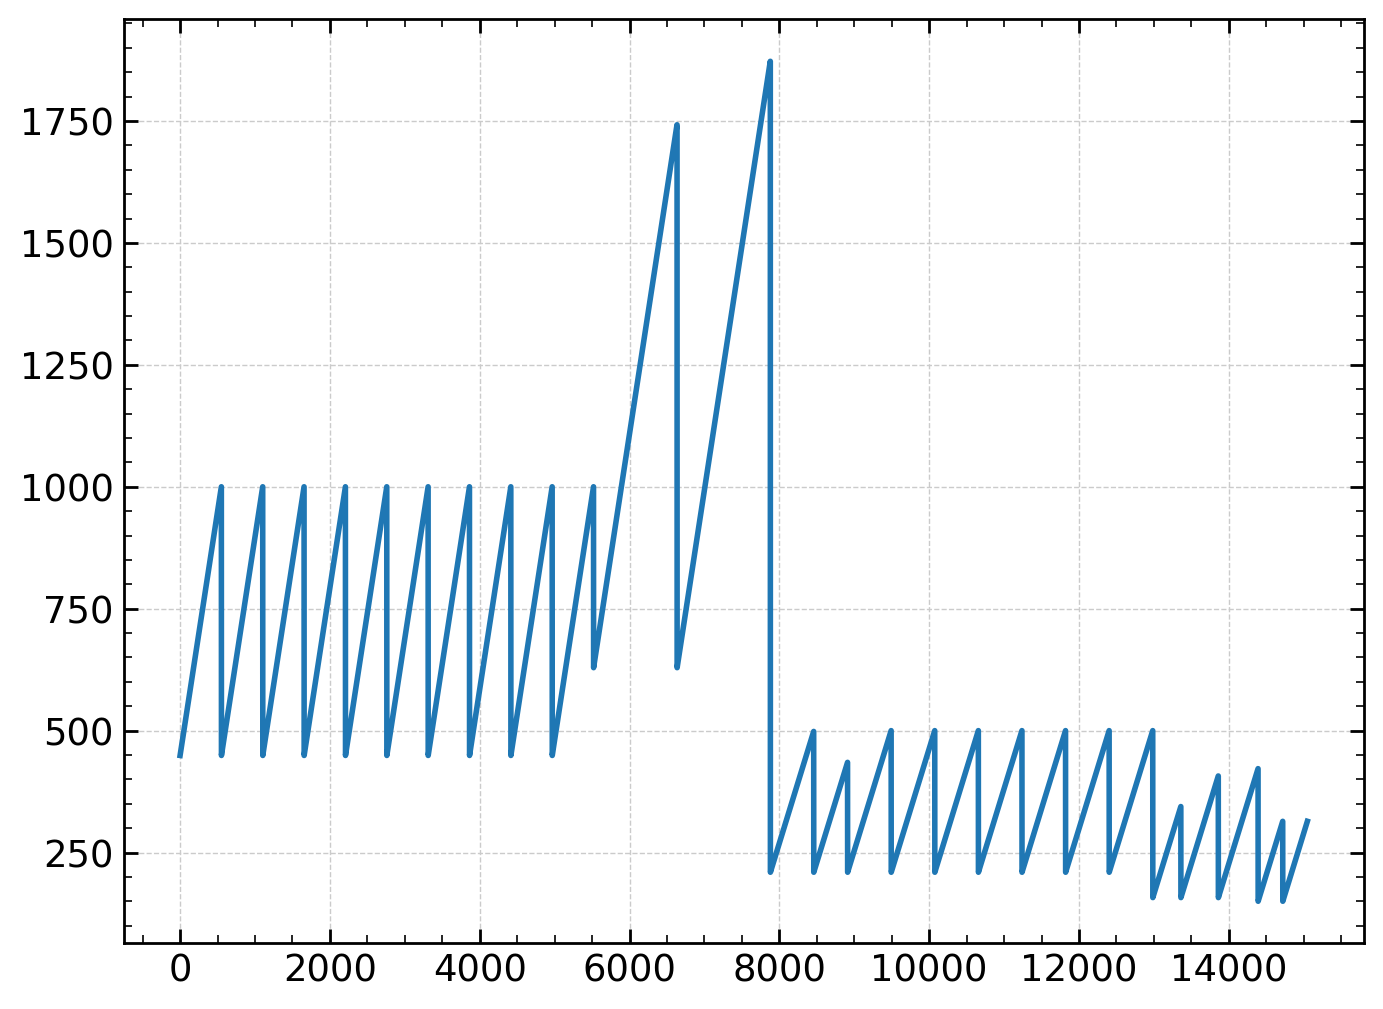

In [5]:
# "pt_df" is a pandas.DataFrame collecting relevant physical quantity time series from 
# all simulations into a long-form array
# it will not be straightforward to bundle each model's points from this data 
pt_df = pd.read_pickle('points_all.p')
pt_logdf = np.log10(pt_df)

# one can bundle data for each model based on "time_code" field 
# that is increasing within each model's data output
plt.plot(pt_df['time_code'])

In [6]:
# "qdset" is a xarray.Dataset storing the (16, 50, 84) percentile values and mean and std for each model's time series into an effectively 3D array.
with xr.open_dataarray('percentiles_all.nc') as qdset:
    # get median values and convert it into pandas.DataFrame
    mid_df = qdset.sel(q='50').to_dataset(dim='variable').drop('q').to_dataframe()
    mid_logdf = np.log10(mid_df)

/Users/ckim/miniconda3/envs/prfm/lib/python3.11/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log10
  result = func(self.values, **kwargs)
/Users/ckim/miniconda3/envs/prfm/lib/python3.11/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: invalid value encountered in log10
  result = func(self.values, **kwargs)


In [7]:
# these are all quantity name stored in this data
# we are mostly interested in fitting "Yxxx" as a function of "W" and "Zgas"
print(qdset['variable'])

<xarray.DataArray 'variable' (variable: 94)>
array(['Ptot', 'Ytot', 'Ptot_top', 'dPtot', 'Pturb', 'Yturb', 'Pturb_top',
       'dPturb', 'Pth', 'Yth', 'Pth_top', 'dPth', 'Pimag', 'Ymag', 'Pimag_top',
       'dPimag', 'oPimag', 'oYmag', 'oPimag_top', 'doPimag', 'dYmag',
       'dPimag_top', 'ddPimag', 'Prad', 'Yrad', 'Prad_top', 'dPrad',
       'Ptot_hot', 'Ytot_hot', 'Ptot_hot_top', 'dPtot_hot', 'Pturb_hot',
       'Yturb_hot', 'Pturb_hot_top', 'dPturb_hot', 'Pth_hot', 'Yth_hot',
       'Pth_hot_top', 'dPth_hot', 'Pimag_hot', 'Ymag_hot', 'Pimag_hot_top',
       'dPimag_hot', 'oPimag_hot', 'oYmag_hot', 'oPimag_hot_top',
       'doPimag_hot', 'dYmag_hot', 'dPimag_hot_top', 'ddPimag_hot', 'Prad_hot',
       'Yrad_hot', 'Prad_hot_top', 'dPrad_hot', 'Ynonth', 'nH',
       'sigma_eff_mid', 'sigma_eff', 'sigma_turb_mid', 'sigma_turb',
       'sigma_th_mid', 'sigma_th', 'H', 'PDE_whole_approx',
       'PDE_2p_avg_approx', 'PDE_2p_mid_approx', 'PDE_whole_full',
       'PDE_2p_avg_full', 'PDE_2p

# fitting with points 

In [8]:
from matplotlib.lines import Line2D

In [9]:
# We are fitting variables as a function of "W" and "Zgas"
# I set the parameter range of interest (in log scale) here
Zmin=-1.3
Zmax=0.3
Wmin=2.7
Wmax=6.3

In [10]:
# setup figure output directory
outdir = './lowZ-figures/'
os.makedirs(outdir,exist_ok=True)

L1 : 0.09686272816235687
L2 : 0.20341357468614352
L1 : 0.239130665588358
L2 : 0.26640996527348126
L1 : 0.13984164668421475
L2 : 0.16909993317380861


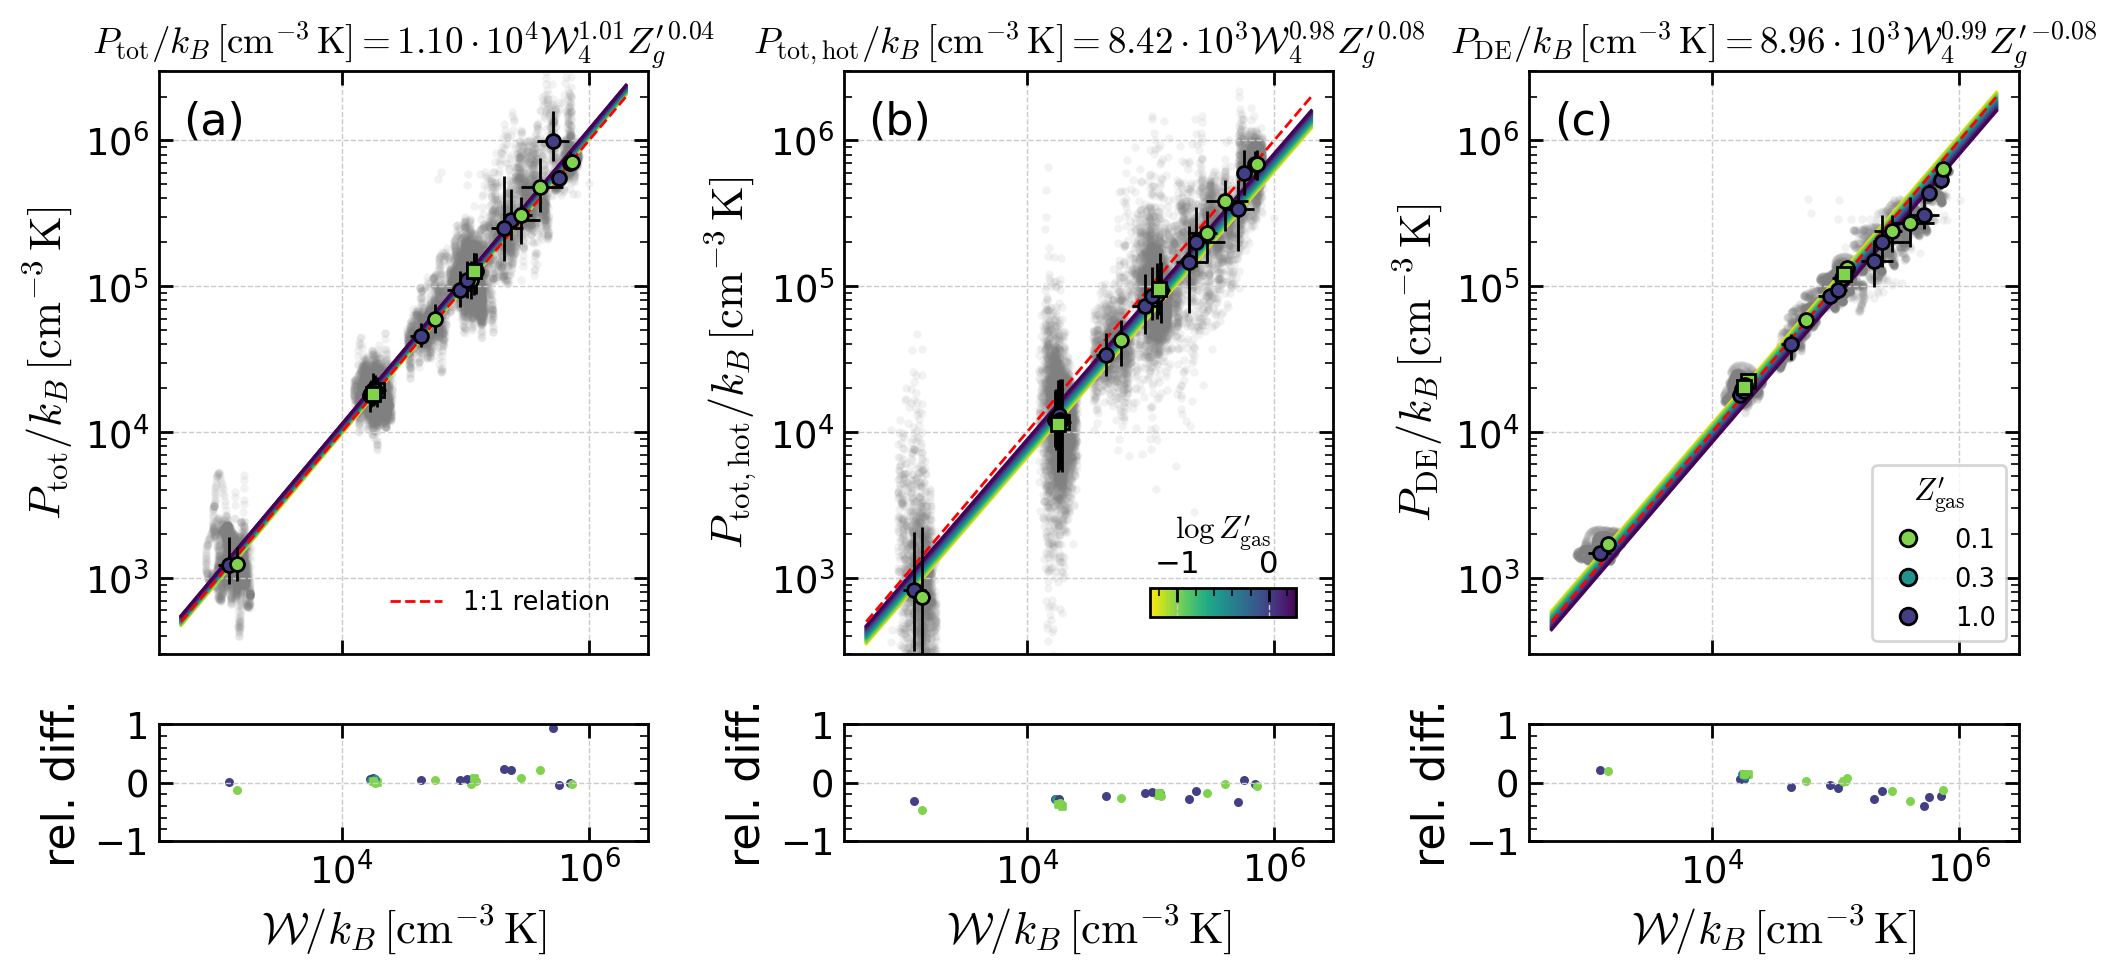

In [11]:
# Figure for 
# (a) vertical dynamical equilibrium (Ptot vs W) 
# (b) pressure equilibrium between phases (Ptot_hot vs W)
# (c) comparison with analytic weight estimator (PDE from Equation 7 in Ostriker & Kim 2022 vs W)
fig,axes_ = plt.subplots(2,3,sharex='col',figsize=(12,5),
                         gridspec_kw=dict(height_ratios=[1,0.2],wspace=0.4,hspace=0.2))

# set field names for x-axes
x1,x2=['W','Zgas']
for yf,axes in zip(['Ptot','Ptot_hot','PDE_2p_avg_approx'],axes_.T):
    # linear regression
    regr = regress(pt_logdf,x1=x1,x2=x2,yf=yf,fit_intercept=False)
    # construct model array from the results
    model_dset = get_model(regr,Zmin=Zmin,Zmax=Zmax,Wmin=Wmin,Wmax=Wmax,dims=[x2,x1])

    # plot simulation data along with fitting result
    plt.sca(axes[0])

    # write fitting result as the axis title
    a=regr.coef_[0]
    b=regr.coef_[1]
    Y0=10**regr.intercept_*1.e4**a
    l = labels[yf] if yf in labels else labels['PDE']
    tit=l+f'$={scifmt(Y0)} \\mathcal{{W}}_4^{{{a:5.2f}}}{{Z_g^\\prime}}^{{{b:5.2f}}}$'
    plt.title(tit,fontsize='small')
    
    # call plotting script
    sm = plot_fitting_points(qdset,model_dset,x1,yf,
                             legend=4 if yf.startswith('PDE') else 0,
                             colorbar=4 if yf.startswith('Ptot_hot') else 0,
                             model=regr,
                             cmap=plt.cm.viridis_r)
    # plot one-to-one line
    plt.plot(model_dset.W,model_dset.W,lw=1,ls='--',color='r')
    # plot all data points as grey dots
    plt.plot(pt_df[x1],pt_df[yf],'.',color='grey',alpha=0.1,mew=0,zorder=-1)
    plt.xlabel('')
    plt.ylim(3.e2,3.e6)
    
    # plot residual by comparing x and y field (not comparing with model; model = False)
    plt.sca(axes[1])
    plot_fitting_points(qdset,model_dset,x1,yf,residual=True,
                        model=False,
                        cmap=plt.cm.viridis_r)

# decorate figure
fig.axes[-1].xaxis.set_ticks_position('top')
fig.axes[-1].xaxis.set_label_position('top')
plt.setp(fig.axes[-1].get_xticklabels(),'fontsize','x-small')
fig.axes[-1].set_xlabel(fig.axes[-1].get_xlabel(),fontsize='x-small')

# add custom legend
plt.sca(axes_[0,0])
custom_lines2 = [Line2D([0], [0], ls = '--', color='r', lw=1)]
leg2 = plt.legend(custom_lines2,['1:1 relation'],loc=4,borderpad=1,fontsize='xx-small',frameon=False)

# add panel label (a), (b), ...
add_panel_labels(axes_[0,:])

# save figure
plt.savefig(os.path.join(outdir,'PW_fit.png'),bbox_inches='tight')

L1 : 0.1421254730328916
L2 : 0.18903782362121535


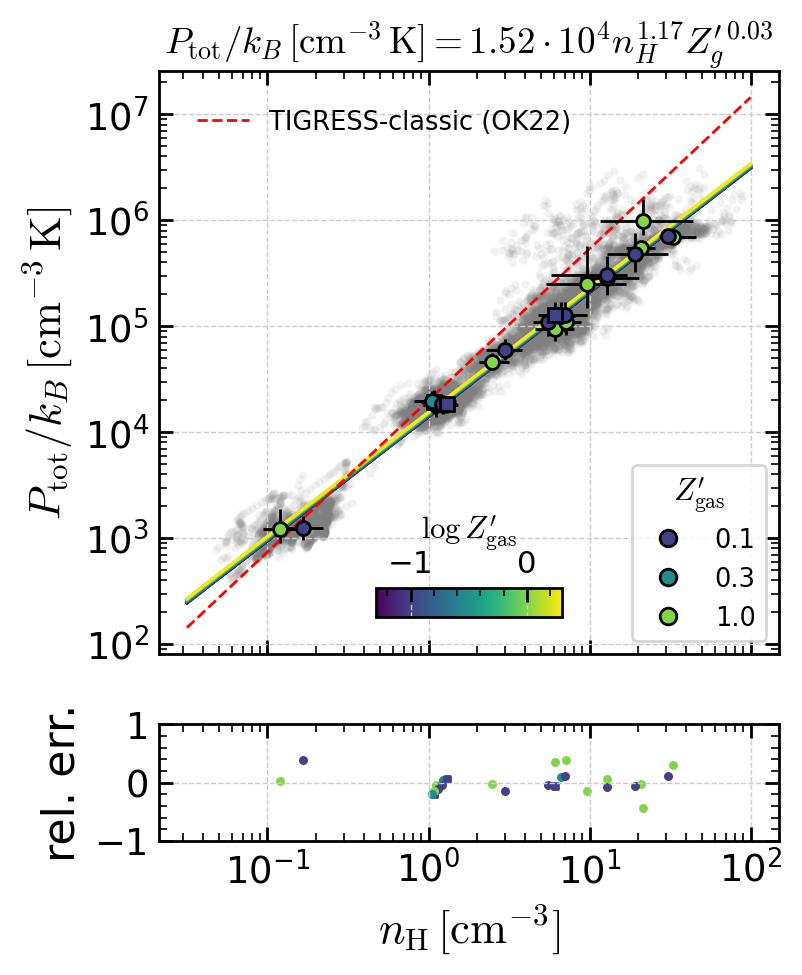

In [12]:
# Figure for the effective Equation of State (eEOS)
fig,axes = plt.subplots(2,1,sharex='col',figsize=(4,5),gridspec_kw=dict(height_ratios=[1,0.2]))

# set field names for x-axes and yaxis
# here we fit Ptot as a function of nH and Zgas
x1,x2,yf=['nH','Zgas','Ptot']

# exclude bad values from the fit
pt_logdf_good = pt_logdf[~pt_logdf[[x1,x2,yf]].isin([np.nan, np.inf, -np.inf]).any(axis=1)].astype('float32')
# linear regression
regr = regress(pt_logdf,x1=x1,x2=x2,yf=yf,fit_intercept=True)
# construct model (not the x1-axis is not W and the parameter range is changed)
model_dset = get_model(regr,Zmin=Zmin,Zmax=Zmax,Wmin=-1.5,Wmax=2,dims=[x2,x1])    

# plot simulation data along with fitting result
plt.sca(axes[0])
# write fitting result as the axis title
a=regr.coef_[0]
b=regr.coef_[1]
Y0=10**regr.intercept_
tit=labels[yf]+f'$={scifmt(Y0)} n_H^{{{a:5.2f}}}{{Z_g^\\prime}}^{{{b:5.2f}}}$'
plt.title(tit,fontsize='small')

# call plotting script
plot_fitting_points(qdset,model_dset,x1,yf,legend=4,colorbar=8,model=regr)
# plot all data as grey dots
plt.plot(pt_df[x1],pt_df[yf],'.',color='grey',alpha=0.1,mew=0,zorder=-1)    
plt.xlabel('')

# plot residual compared with the fitting result
plt.sca(axes[1])
plot_fitting_points(qdset,model_dset,x1,yf,residual=True,model=regr)

# add reference line from the previous result (Ostriker & Kim 2022 Eq 27, Figure 14)
nH=model_dset.nH.data
plt.sca(axes[0])
plt.plot(nH,10**4.3*nH**1.43,ls='--',color='r',lw=1)
leg1=plt.gca().get_legend()
custom_lines2 = [Line2D([0], [0], ls = '--', color='r', lw=1)]
leg2 = plt.legend(custom_lines2,['TIGRESS-classic (OK22)'],loc=2,borderpad=1,fontsize='xx-small',frameon=False)
plt.gca().add_artist(leg1)

# decorate axis
fig.axes[-1].xaxis.set_ticks_position('top')
fig.axes[-1].xaxis.set_label_position('top')
plt.setp(fig.axes[-1].get_xticklabels(),'fontsize','x-small')
fig.axes[-1].set_xlabel(fig.axes[-1].get_xlabel(),fontsize='x-small')

# save figure
plt.savefig(os.path.join(outdir,'eEOS_fit.png'),bbox_inches='tight')

Ytot
L1 : 0.27556926023153927
L2 : 0.42743844119100705
Yth
L1 : 0.15858170676280017
L2 : 0.24654745389958077
Yturb
L1 : 0.22683973141040384
L2 : 0.3077072875315655
Ynonth
L1 : 0.3020861001958218
L2 : 0.5019367093334518
Ymag
L1 : 1.1452892664078147
L2 : 2.878748323456985
oYmag
L1 : 3.531028132300873
L2 : 11.091955767740236
dYmag
L1 : 0.5994386215503428
L2 : 1.2156750185224072


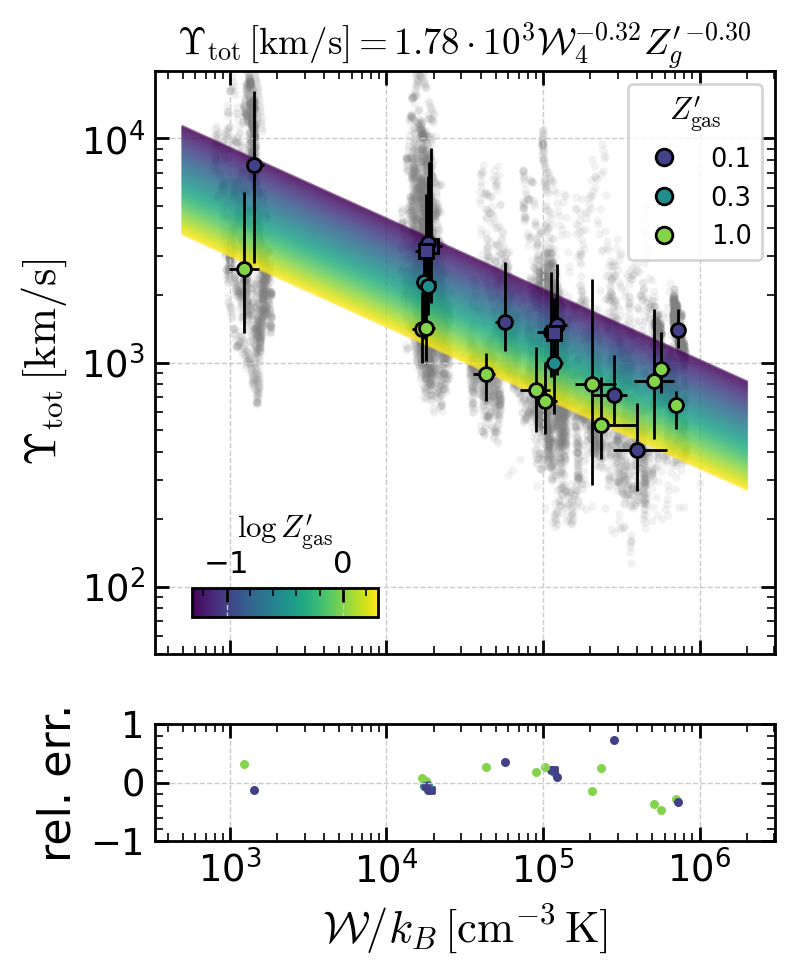

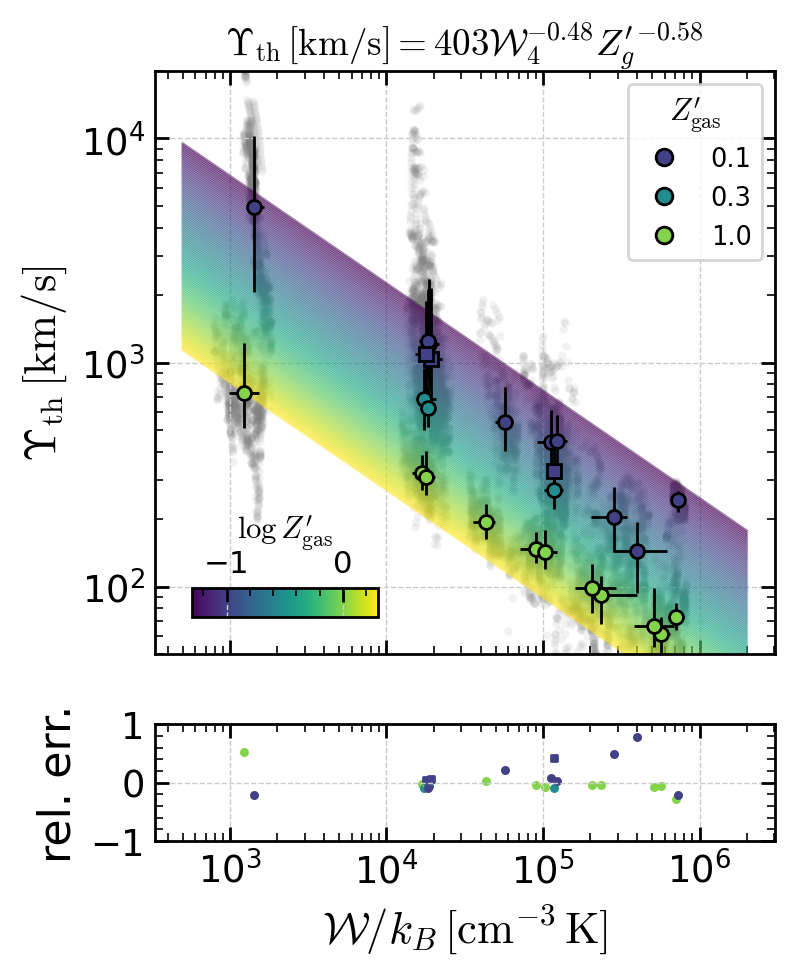

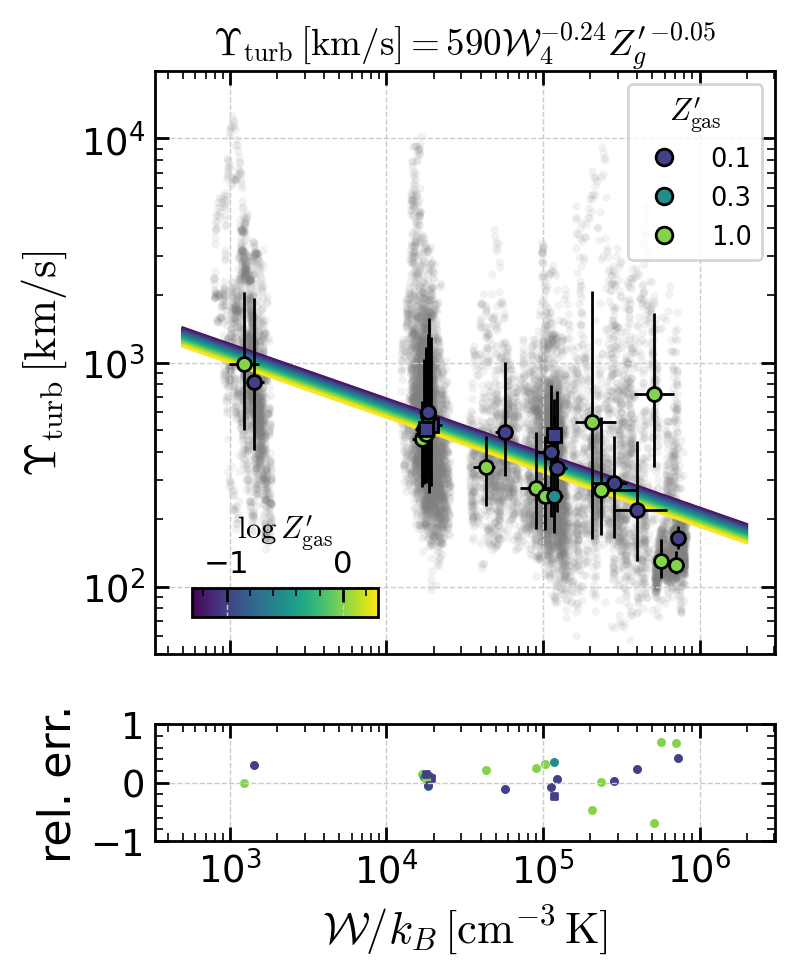

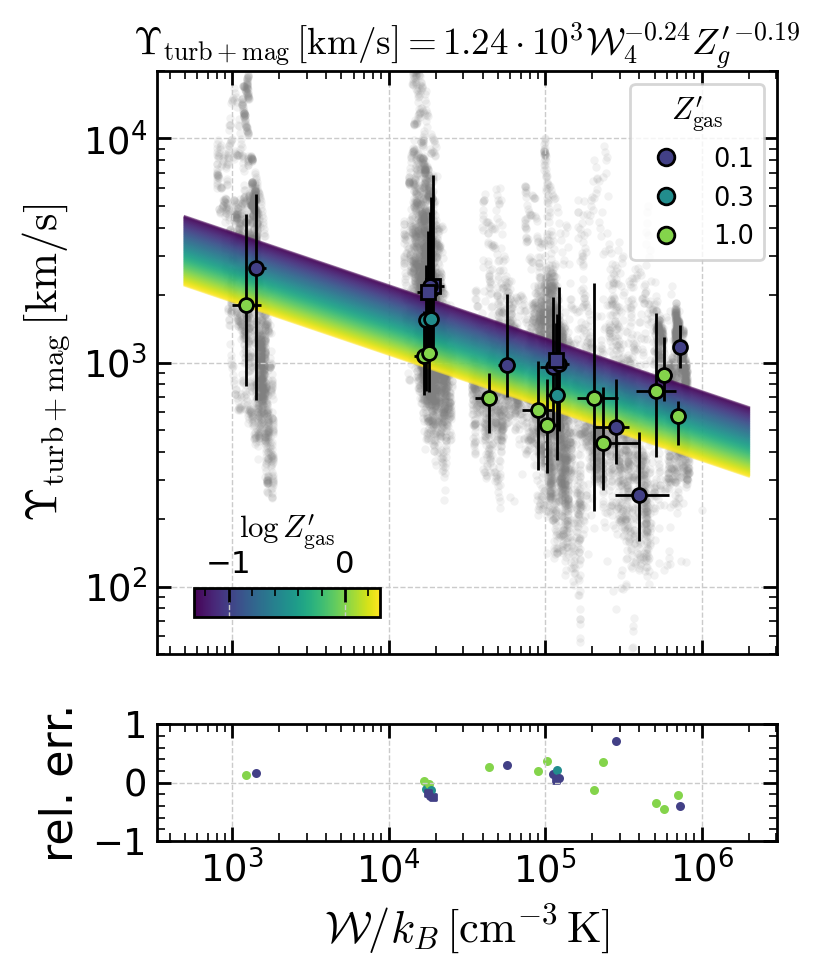

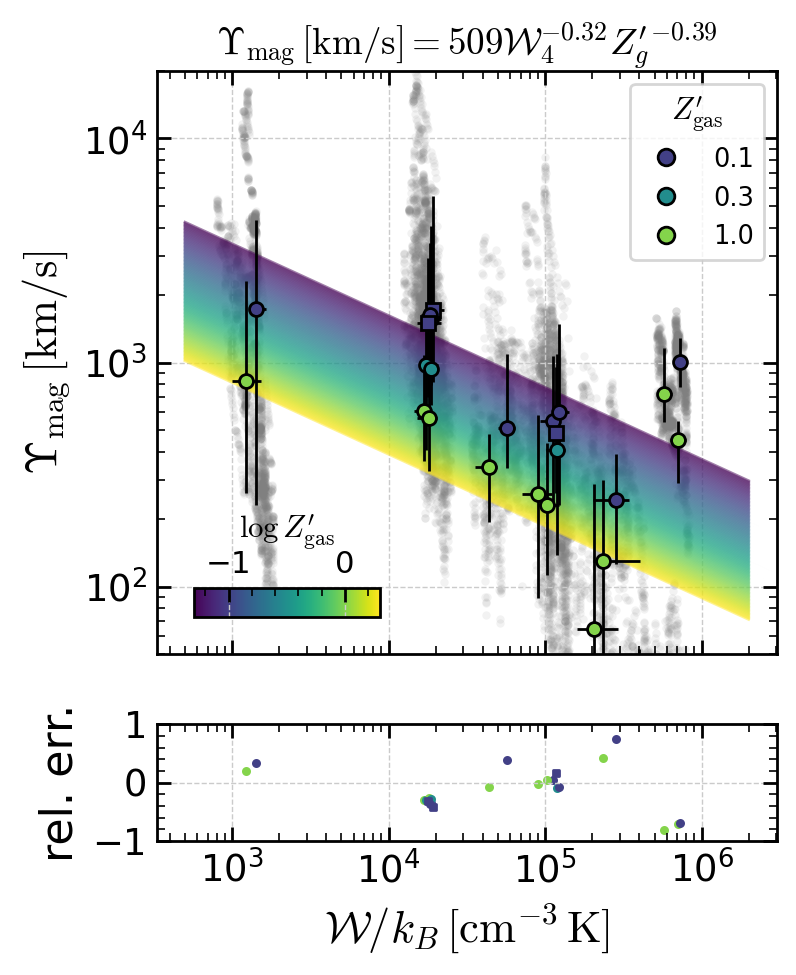

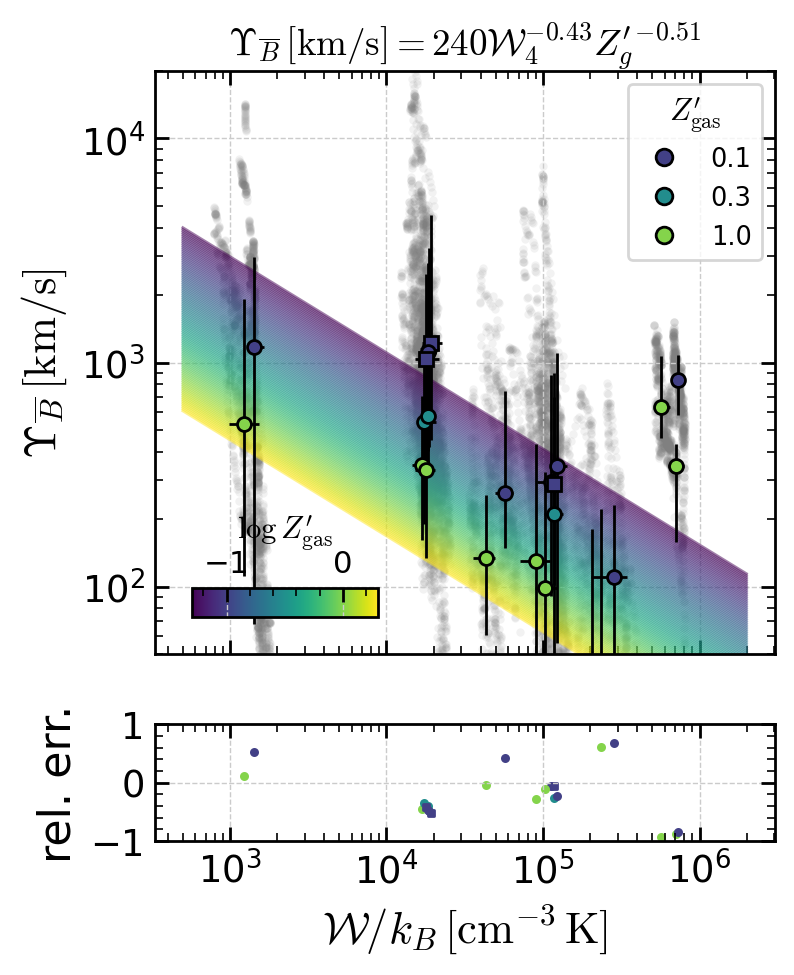

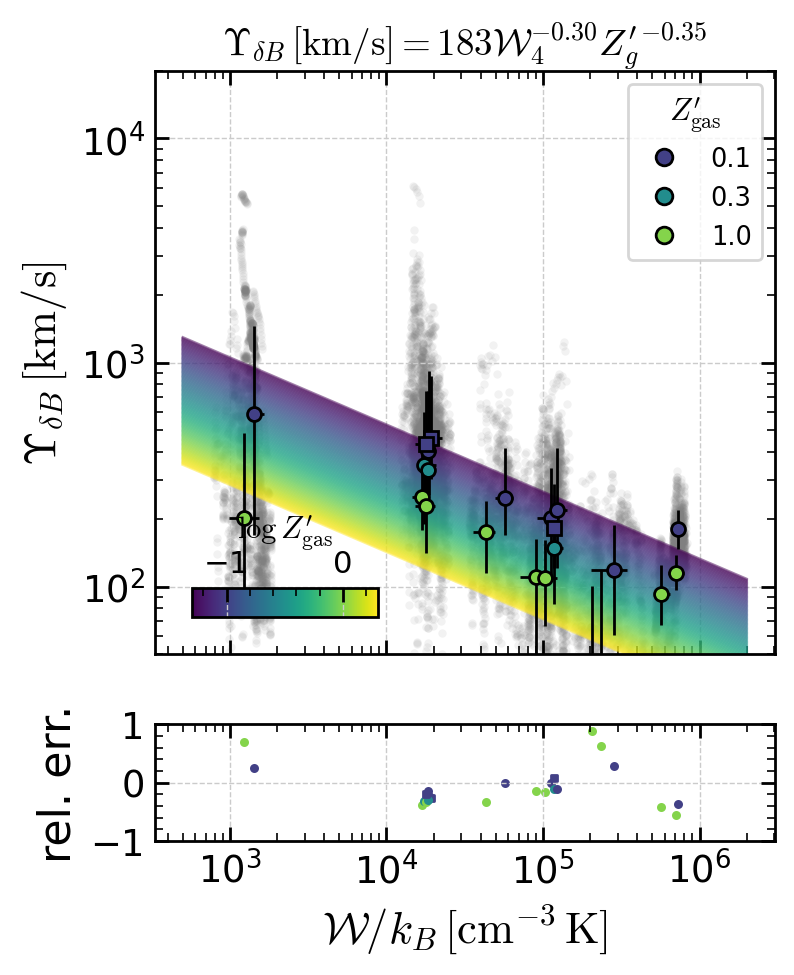

In [13]:
# Figure for feedback yields (each component saved into each figure)
for yf in ['Ytot','Yth','Yturb','Ynonth','Ymag','oYmag','dYmag']:
    fig,axes = plt.subplots(2,1,sharex='col',figsize=(4,5),gridspec_kw=dict(height_ratios=[1,0.2]))

    # set field names for x-axes and yaxis
    x1,x2=['W','Zgas']

    # exclude bad values from the fit
    pt_logdf_good = pt_logdf[~pt_logdf[[x1,x2,yf]].isin([np.nan, np.inf, -np.inf]).any(axis=1)].astype('float32')
    # linear regression
    regr = regress(pt_logdf_good,x1=x1,x2=x2,yf=yf,fit_intercept=True)
    # construct model
    model_dset = get_model(regr,Zmin=Zmin,Zmax=Zmax,Wmin=Wmin,Wmax=Wmax)  

    # plot simulation data along with fitting result
    plt.sca(axes[0])

    # write fitting result as the axis title
    a=regr.coef_[0]
    b=regr.coef_[1]
    Y0=10**regr.intercept_*1.e4**a
    tit=labels[yf]+f'$={scifmt(Y0)} \\mathcal{{W}}_4^{{{a:5.2f}}}{{Z_g^\\prime}}^{{{b:5.2f}}}$'
    plt.title(tit,fontsize='small')

    # call plotting script
    plot_fitting_points(qdset,model_dset,x1,yf,legend=1,colorbar=3,model=regr)
    # plot all data as grey dots
    plt.plot(pt_df[x1],pt_df[yf],'.',color='grey',alpha=0.1,mew=0,zorder=-1)
    plt.ylim((5.e1,2.e4))
    plt.xlabel('')

    # plot residual compared with the fitting result
    plt.sca(axes[1])
    print(yf)
    plot_fitting_points(qdset,model_dset,x1,yf,residual=True,model=regr)

    # decorate axis
    fig.axes[-1].xaxis.set_ticks_position('top')
    fig.axes[-1].xaxis.set_label_position('top')
    plt.setp(fig.axes[-1].get_xticklabels(),'fontsize','x-small')
    fig.axes[-1].set_xlabel(fig.axes[-1].get_xlabel(),fontsize='x-small')
    
    # save figure
    plt.savefig(os.path.join(outdir,f'{yf}_fit.png'),bbox_inches='tight')

L1 : 0.2508380457195896
L2 : 0.3935322910945434


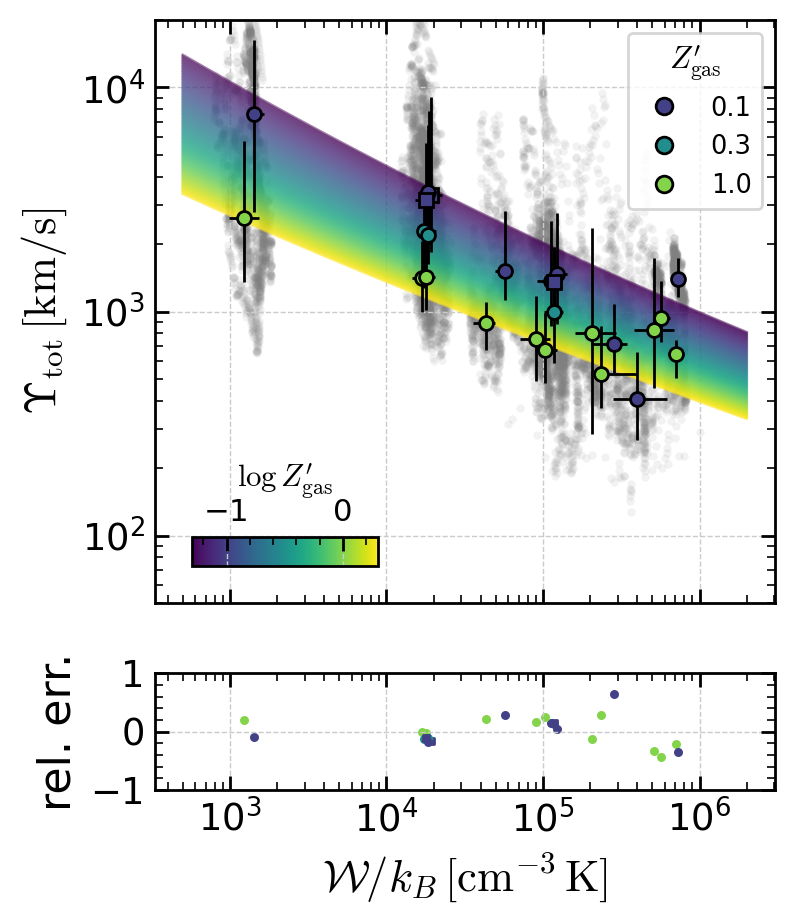

In [14]:
# Figure for total feedback yield compared with 
# the model based on thermal + nonthermal (turbulent+magnetic)
fig,axes = plt.subplots(2,1,sharex='col',figsize=(4,5),gridspec_kw=dict(height_ratios=[1,0.2]))

x1,x2=['W','Zgas']

# fitting for thermal feedback yield
yf = 'Yth'
pt_logdf_good = pt_logdf[~pt_logdf[[x1,x2,yf]].isin([np.nan, np.inf, -np.inf]).any(axis=1)].astype('float32')
regr = regress(pt_logdf_good,x1=x1,x2=x2,yf=yf,fit_intercept=True)
model_dset1 = get_model(regr,Zmin=Zmin,Zmax=Zmax,Wmin=Wmin,Wmax=Wmax)

# fitting for non-thermal feedback yield
yf = 'Ynonth'
pt_logdf_good = pt_logdf[~pt_logdf[[x1,x2,yf]].isin([np.nan, np.inf, -np.inf]).any(axis=1)].astype('float32')
regr = regress(pt_logdf_good,x1=x1,x2=x2,yf=yf,fit_intercept=True)
model_dset2 = get_model(regr,Zmin=Zmin,Zmax=Zmax,Wmin=Wmin,Wmax=Wmax,nZ=100,nW=100)

# get total feedback yield model by summing up two
model_dset = model_dset1+model_dset2

# plot results
plt.sca(axes[0])
plot_fitting_points(qdset,model_dset,x1,'Ytot',legend=1,colorbar=3)
plt.plot(pt_df[x1],pt_df['Ytot'],'.',color='grey',alpha=0.1,mew=0,zorder=-1)
plt.ylim((5.e1,2.e4))

plt.sca(axes[1])
plot_fitting_points(qdset,model_dset,x1,'Ytot',residual=True)

axes[0].set_xlabel('')
fig.axes[-1].xaxis.set_ticks_position('top')
fig.axes[-1].xaxis.set_label_position('top')
plt.setp(fig.axes[-1].get_xticklabels(),'fontsize','x-small')
fig.axes[-1].set_xlabel(fig.axes[-1].get_xlabel(),fontsize='x-small')

plt.savefig(os.path.join(outdir,f'Ytot_fit2.png'),bbox_inches='tight')